# Tutorial Patient A1 - detailled

This tutorial provides a detailled overview of every step of the analysis pipeline for one patient. We highlight the filtering step, as well as the result selection and evaluation.

The patient analysed in this notebook in patient A1 from the following publication: 
[S. Beneyto-Calabuig, et al. (2023) Clonally resolved single-cell multi-omics identifies routes of cellular differentiation in acute myeloid leukemia](https://doi.org/10.1016/j.stem.2023.04.001)

The tutorial starts with the unfiltered anndata object. To do variant calling with cellSNP-lite, and create this object from an input BAM file, please follow the steps outlined in "(1) Preprocessing" in the ../scripts directory.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import anndata

adata=anndata.read_h5ad("A1/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 4160 × 2002
    var: 'chr', 'pos', 'ref', 'mut', 'REDIdb', 'dbSNP', 'gene'
    layers: 'ALT', 'REF'

## I. Variant filtering

The unfiltered adata object contains 2002 variants. As we use no prior knownledge in variant calling, we expect most variants in that set to be of non-somatic origin, i.e. germline variants or errors. 

#### Low frequency variants

We would like to filter this set of variants to try and keep mostly variants allowng us to recognise the healhty and cancer populations. As we use co-occuring sets of variants to that effect, variants that are seen accross all cells, or in almost no cells are not informative. So we can have a look at the frequency of the rarest allele:

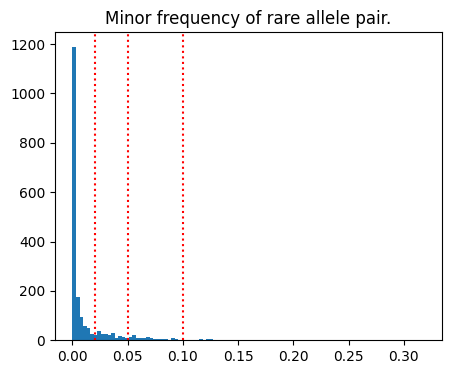

In [4]:
REF, ALT = adata.layers["REF"].A, adata.layers["ALT"].A
cov = REF + ALT
only_REF_cells = np.sum((REF > 1) & (ALT == 0), axis=0) # cells with only ref reads
only_ALT_cells = np.sum((REF == 0) & (ALT > 1), axis=0) # cells with only alt reads
ALT_cells = np.sum((ALT>1), axis=0) # number of heterozygous cells
REF_cells = np.sum((REF>1), axis=0) # number of heterozygous cells

min_MAF = np.nanmax((np.nanmin((only_REF_cells, ALT_cells), axis=0),
                     np.nanmin((only_ALT_cells, REF_cells), axis=0)),
                     axis=0)

plt.subplots(1,1,figsize=(5, 4))
plt.hist(min_MAF/adata.shape[0], bins=100)
plt.axvline(.1, color="red", linestyle =":")
plt.axvline(.05, color="red", linestyle =":")
plt.axvline(.02, color="red", linestyle =":")
plt.title("Minor frequency of rare allele pair.")
plt.show()

Variants found in very few cells are not really informative, and can add noise making the identification of clones more difficult. However it can be difficult to decide how few is too few. Especially as we do not know the clonal population size. Clearly, the peak very close to 0 needs to be excluded. But beyond that? is 2% too small? 5%? Do we exclude too many informative variants at 10%?

In this work we found that different thresholds worked best for different samples. Because of this, we simply try all 3 thresholds and later select the most informative set.


#### Germline variants

In theory, germline variants found accross cells are also not informative. Because of this in preprocessing (not included in this notebook), we used vep to identify and annotate all our variants that are also found in the common variant set of dbSNP (found in at >=1% frequency in at least one major population.

This information can be found in the adata.var["dbSNP"] columns (note: the position and allele columns where blanked out for data protection purposes):

In [5]:
adata.var

,chr,pos,ref,mut,REDIdb,dbSNP,gene
0,chr1,,,,False,True,"ENSG00000067606:downstream_gene_variant,ENSG00..."
1,chr1,,,,False,False,"ENSG00000116251:3_prime_UTR_variant,ENSG000001..."
2,chr1,,,,False,False,"ENSG00000116251:5_prime_UTR_variant,ENSG000001..."
3,chr1,,,,False,False,"ENSG00000074800:3_prime_UTR_variant,NMD_transc..."
4,chr1,,,,False,True,"ENSG00000077549:3_prime_UTR_variant,ENSG000000..."
...,...,...,...,...,...,...,...
2532,chr22,,,,False,False,"ENSG00000100216:3_prime_UTR_variant,ENSG000001..."
2534,chr22,,,,False,True,"ENSG00000100226:downstream_gene_variant,ENSG00..."
2538,chr22,,,,False,True,"ENSG00000177096:downstream_gene_variant,ENSG00..."
2539,chr22,,,,False,True,"ENSG00000100300:downstream_gene_variant,ENSG00..."


We can also have a look at the frequency of these variants. If they are true germline variants, we expect them to be found at close to .5 VAF:

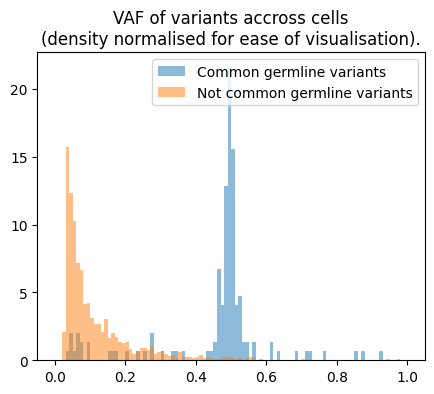

In [6]:
REF_cells = np.sum((REF > 0), axis=0) # cells with only ref reads
ALT_cells = np.sum((ALT > 0), axis=0) # cells with only alt reads

plt.subplots(1,1,figsize=(5, 4))
c1=(ALT_cells/(REF_cells+ALT_cells))[adata.var.dbSNP]
c2=(ALT_cells/(REF_cells+ALT_cells))[~adata.var.dbSNP]

plt.hist(c1, bins=100, range=(0,1), alpha=.5, label="Common germline variants", density=True)
plt.hist(c2, bins=100, range=(0,1), alpha=.5, label="Not common germline variants", density=True)
plt.title("VAF of variants accross cells\n(density normalised for ease of visualisation).")
plt.legend()
plt.show()

Compared to the varants not annotated in dbNSP, the VAF of these variants is indeed much closer to 0.5. However, we can see that this is not always the case. These variants with VAF very far of 0.5 could be due to noise, or perhaps they are not germline variants in our dataset. Or maybe they are germline variants and were disbalanced in one of the clone due to a LOH or a somatic variant in the regulatory region on one allele. In this last case they would be informative.

Here too, it is not easy to decide whether to exclude or keep this set of variant. Because of this, we again try different threshold (with and without dbSNP-common variants) and later select the best result.

#### Alternatives

Alternatively, you can use different thresholds for your data. In particular, in the presence of prior knowledge, it can be used to help filter the variants. Some examples:
 - if there are known healthy and cancer (sub-)populations (in addition to the mixed populations), the variants exclusive to either populations can be kept as informative, and the other excluded. However, this could result in the exclusion of informative variants that are not sufficiently covered in any of these populations.
 - if you have a known somatic event in your data (or partial cancer cell labels) you could test for all variants whether they are significantly positively or negatively associated with this known pattern and only keep those for downstream analysis (through a chi2 test). Here too, this would only work if the reference and tested variant position are found covered in sufficiently high number of cells.
 
 
#### Result variant subset sizes

In this work, we thus use the different filter mentioned above, resulting in the following input data of different sizes:

In [7]:
adata.layers["REF"] = adata.layers["REF"].A
adata.layers["ALT"] = adata.layers["ALT"].A

In [11]:
from passenger.preprocess.filter import filter_vars

for filter_germline in [True, False]:
    for min_MAF in 2, 5, 10:
        adata_ = filter_vars(adata.copy(), filter_germline=filter_germline, min_MAF=min_MAF)
        print("Filter germline: "+str(filter_germline) + "\t\tMin MAF: "+str(min_MAF))
        print("\tafter filtering object has: " + str(adata_.shape[1]) + " variants.")
        print()

Filter germline: True		Min MAF: 2
	after filtering object has: 168 variants.

Filter germline: True		Min MAF: 5
	after filtering object has: 64 variants.

Filter germline: True		Min MAF: 10
	after filtering object has: 11 variants.

Filter germline: False		Min MAF: 2
	after filtering object has: 291 variants.

Filter germline: False		Min MAF: 5
	after filtering object has: 120 variants.

Filter germline: False		Min MAF: 10
	after filtering object has: 21 variants.



## II. Run wNMF

We want to run the wNMF on each generate variant subset. The wNMF takes one main parameter as input: **k, the number of factors**. Ideally this parameter k should reflect the number of factors clearly identifyable from the data. Again, this is typically not known. Because of this here too, we run the wNMF with a range of k (2-3 in this example), and select the best k.

Given this parameter, the wNMF can then be run with:

In [12]:
# bootstrap_wNMF(adata, k=k)

However, as this step is quite time consuming and can take a couple of hours, we recommend to run it for each variant subset as a separate job. The script to do variant filtering and run the wNMF can be found in ../scripts/run_wNMF.py

For this notebook, we submitted 12 separate jobs to run the filtering and WNMF with following parameters:
```
python run_wNMF.py -d ../tutorials/A1/ -k 2 --min_MAF 2
python run_wNMF.py -d ../tutorials/A1/ -k 2 --min_MAF 5
python run_wNMF.py -d ../tutorials/A1/ -k 2 --min_MAF 10

python run_wNMF.py -d ../tutorials/A1/ -k 2 --min_MAF 2 --keep_germline
python run_wNMF.py -d ../tutorials/A1/ -k 2 --min_MAF 5 --keep_germline
python run_wNMF.py -d ../tutorials/A1/ -k 2 --min_MAF 10 --keep_germline


python run_wNMF.py -d ../tutorials/A1/ -k 3 --min_MAF 2
python run_wNMF.py -d ../tutorials/A1/ -k 3 --min_MAF 5
python run_wNMF.py -d ../tutorials/A1/ -k 3 --min_MAF 10

python run_wNMF.py -d ../tutorials/A1/ -k 3 --min_MAF 2 --keep_germline
python run_wNMF.py -d ../tutorials/A1/ -k 3 --min_MAF 5 --keep_germline
python run_wNMF.py -d ../tutorials/A1/ -k 3 --min_MAF 10 --keep_germline

```
This gava us the 12 output files saved in ```A1/out*.h5ad```

Now these 12 runs can have very different results. 